# FINM 359000 Macro Finance
### Problem Set 2
##### Group Members:
- Hongsen (Henry) Fu
- Huayu (Alaia) Zhu
- Mange (Kevin) He
- Yuxuan (Ryan) Bai

##### Import Libraries and Helper Functions 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime 
from func import * 
import seaborn as sns 

## Part 3. Risk Parity 

##### Data Fetching & Preprocessing 

In [2]:
# Set the date range we want to analyze 
start = '2000-01-01'
end = datetime.now().strftime('%Y-%m-%d')

In [3]:
# Get the data
df_spy = get_stock_data('SPY', start, end).rename(columns={'adj_close':'price'})
df_bond = get_bond_data('DGS10', start)
df_bond = yield_to_price(df_bond, 'US').loc[:,['price']] # Convert yield to price

In [4]:
# Get the weekly return data 
df_spy_ret = calculate_weekly_return(df_spy)
df_bond_ret = calculate_weekly_return(df_bond)

### 8. Observing Correlation 

#### a. From HW 1 you should already have total returns series for US stocks and bonds since 2000. Using weekly returns, estimate the full sample equity-bond return correlation from 2000 to 2019 (inclusive).

Here, we utilized SPY as the proxy for US stocks instead of the commonly used SP500 (SPX), as it is a tradable ETF. This choice facilitates the construction of our portfolio and strategy in subsequent questions. The bonds selected are US 10-year bonds from HW1. Subsequently, we computed the weekly returns, factoring in business dates and holidays, and derived the full sample equity-bond return correlation spanning from 2000 to 2019. The correlation between SPY (representing US stocks) and US 10-year bonds (representing US bonds) is notably modest, approximately 0.34. While they exhibit movements in the same direction, suggesting potential similar reactions to certain macro events, the correlation remains relatively low.

In [5]:
df_ret_2000_2019 = pd.concat([df_spy_ret, df_bond_ret], axis=1,).loc['2000':'2019']
df_ret_2000_2019.columns = ['SPY', 'Bond']

In [6]:
df_ret_2000_2019.corr()

,SPY,Bond
SPY,1.000000,0.343921
Bond,0.343921,1.000000


- Plot of correlation between SPY and Bond:

<Axes: >

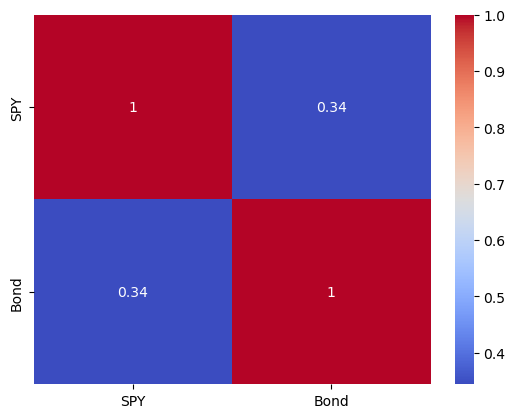

In [7]:
sns.heatmap(df_ret_2000_2019.corr(), annot=True, cmap='coolwarm')

#### b.Now estimate the rolling 1-year equity-bond return correlation over the same sample. What do you notice?

The rolling 1-year correlation between equity (SPY) and bond returns from 2000 to 2019 shows not just a similar mean to the overall sample correlation, but also a high standard deviation, highlighting substantial fluctuations over time. These fluctuations range from a minimum of -0.6727 (2006-05-10) to a maximum of 0.8936 (2010-07-14). The visual pattern in the plot indicates a cyclical behavior in correlation, with periods of rising and falling every few years. However, the cycles do not have a fixed time range, reducing the predicting power. 

For investors employing a risk parity strategy or generally employing a diversification strategy, understanding these correlation dynamics is crucial. Risk parity strategy involves allocating portfolio weights inversely proportional to asset risk, aiming for equal risk contribution from all assets. Given the volatile nature of equity-bond correlations, the expected risk contribution from these assets can change significantly, affecting the portfolio balance. During periods of rising correlation, bonds may offer less diversification benefit against equities, potentially increasing portfolio risk if not rebalanced accordingly. Conversely, periods of negative or low correlation enhance the effectiveness of bonds in providing a hedge against equity risk. Thus, continuous monitoring and dynamic adjustment of asset weights are essential for maintaining the intended risk parity across the portfolio. This approach not only helps in achieving a more stable risk profile but also in navigating through different macroeconomic conditions that might influence asset correlations.

In [26]:
df_rolling_corr = df_ret_2000_2019.rolling(52).corr().unstack().loc[:,'SPY'].dropna()
#display(df_rolling_corr.head(5))

In [27]:
df_rolling_corr.loc[:,['Bond']].describe()

,Bond
count,3299.000000
mean,0.320287
std,0.341046
min,-0.672699
25%,0.078054
50%,0.404819
75%,0.602753
max,0.893569


In [28]:
print(f"Maximum correlation date: {df_rolling_corr.loc[:, ['Bond']].idxmax()}")
print(f"Minimum correlation date: {df_rolling_corr.loc[:, ['Bond']].idxmin()}")


Maximum correlation date: Bond   2010-07-14
dtype: datetime64[ns]
Minimum correlation date: Bond   2006-05-10
dtype: datetime64[ns]


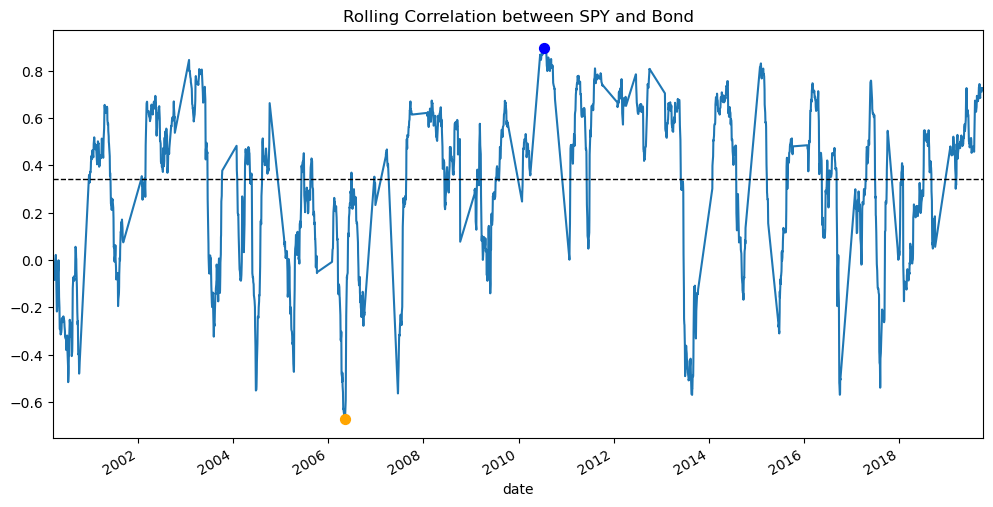

In [29]:
plot_rolling_corr(df_rolling_corr['Bond'],0.34)

### 9. Historical performance


#### a. Suppose you manage a risk parity fund where you allocate the same risk budget to US stocks and to bonds, using as your measure of risk the 1-year trailing return volatility. No leverage, buying on margin or shorting are allowed. What would be the allocation to stocks and bonds, on average, over the life of the fund from 2000 to 2019. Plot how this allocation changes over time.


The risk parity strategy setup logic: 

We know that from portfolio class, risk of the portfolio is calculated by $\sigma_p^2 = \Sigma^n_{i=1}\Sigma_{j=1}^n w_i w_j \sigma_{i,j} = w_1^2 \sigma_1^2 + + w_2^2 \sigma_2^2 + 2w_1w_2 \sigma_{i,j}$.

We then consider the marginal risk contribution, the contribution to total risk from each asset, adjusted for how assets interact through correlation. We adjust the weights and ensure that each asset contributes equally to the portfolio. 

After we constructed our strategy, we decide to adjust the weight every week beginning from Dec 29, 2000 to Dec 27, 2019. The average weight of the stock (SPY) is 0.556174, and the average weight of the bond(US 10 year) is 0.443826. We can see over the 2000-2019 time period, we slightly put more emphasize on SPY, but the weight of those two are quite balanced if looking at mean. However, if we take a closer look of the plot, we can see that the change of weight is quite frequent and volatile. 

In [31]:
df_rolling_vol = df_ret_2000_2019.rolling(52).std().dropna() #calculate 1year trailing return vol 

- Plot of the rolling volatility: 

<Axes: xlabel='date'>

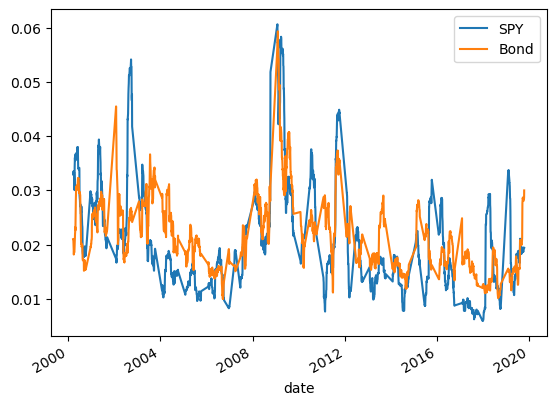

In [14]:
df_rolling_vol.plot()

In [15]:
weight_rp = equal_risk_parity(df_rolling_vol,df_rolling_corr)

In [16]:
weight_rp.mean()

weight stock    0.556174
weight bond     0.443826
dtype: object

- Plot of the weight allocation: 

<Axes: xlabel='date'>

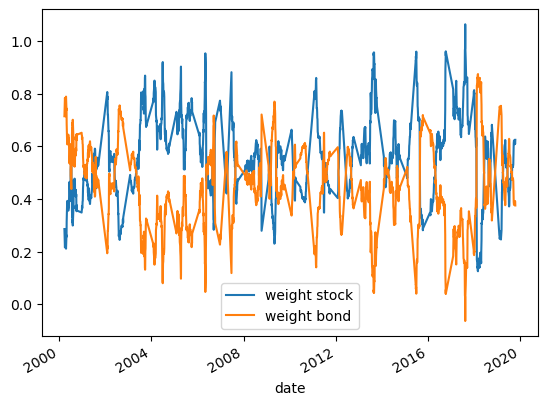

In [17]:
weight_rp.plot()

#### b. What would the average risk of the fund be from 2000 to 2019? How does this change over time? What amount is due to equity and what amount due to bonds?


The average risk of the fund from 2000 to 2019 is roughly 0.442619. It increases and decreases cyclically over time. Since, we used the equal risk parity strategy before, the risk contribution should equally separated to equity and bond. 

In [33]:
def calculate_portfolio_risk(row):
    bond_vol = row['Bond']
    spy_vol = row['SPY']
    corr = row['Correlation']
    weight_bond = row['weight bond']
    weight_spy = row['weight stock']
    
    portfolio_variance = (weight_bond * bond_vol)**2 + (weight_spy * spy_vol)**2 + 2 * weight_bond * weight_spy * corr
    return np.sqrt(portfolio_variance)

df_rolling_corr = df_rolling_corr.rename(columns={'Bond': 'Correlation'})
portfolio_risk = pd.concat([df_rolling_vol, df_rolling_corr[['Correlation']], weight_rp], axis=1)

portfolio_risk['portfolio risk'] = portfolio_risk.apply(calculate_portfolio_risk, axis=1)
portfolio_risk = portfolio_risk[['portfolio risk']].dropna() 


- mean of portfolio risk: 

In [35]:
portfolio_risk.describe()

,portfolio risk
count,2652.000000
mean,0.442619
std,0.140126
min,0.007577
25%,0.358482
50%,0.471280
75%,0.555504
max,0.657617


- plot of portfolio risk over time 

<Axes: xlabel='date'>

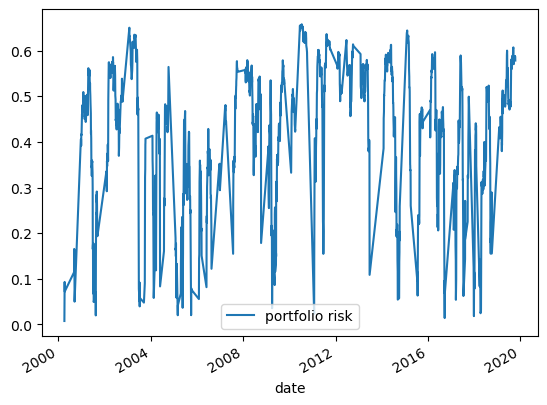

In [36]:
portfolio_risk.plot()

#### c. Why do you think risk parity is a strategy that is followed, particularly in this case as it relates to stock and bonds?


### 10. 2021 to the present


#### a. From 2021 to the present (2022 in particular), what happened to a fund’s performance if the fund followed the risk parity strategy we have thus far outlined?


If the fund follows the strategy we outlined, the overall sharpe ratio of the portfolio will be 0.0683, the sharpe ratio over 2022 would be 0.0949. Comparing with extreme negative sharpe ration in 2022 for bond, the strategy overall improved the result. 

In [57]:
df_ret_2021_2024 = pd.concat([df_spy_ret, df_bond_ret], axis=1,).loc['2021':'2024'].dropna()
df_ret_2021_2024.columns = ['SPY', 'Bond']
df_rolling_corr_fut = df_ret_2021_2024.rolling(52).corr().unstack().loc[:,'SPY'].dropna()
df_rolling_vol_fut = df_ret_2021_2024.rolling(52).std().dropna()

In [58]:
df_weight_fut = equal_risk_parity(df_rolling_vol_fut,df_rolling_corr_fut)

- plot of weight allocation over time: 

<Axes: xlabel='date'>

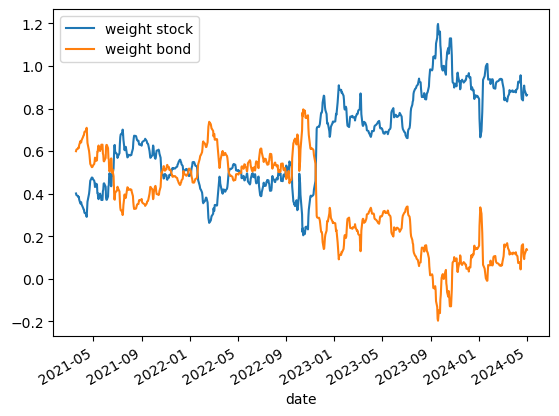

In [59]:
df_weight_fut.plot()

In [62]:
def calculate_portfolio_return(row):
    weight_bond = row['weight bond']
    weight_spy = row['weight stock']
    ret_bond = row['Bond return']
    ret_spy = row['SPY return']
    
    portfolio_return = weight_bond * ret_bond + weight_spy * ret_spy 
    return portfolio_return

In [83]:
df_rolling_corr_fut = df_rolling_corr_fut.rename(columns={'Bond': 'Correlation'})
df_ret_2021_2024 = df_ret_2021_2024.rename(columns = {'Bond': 'Bond return', 'SPY':'SPY return'})
portfolio_analysis = pd.concat([df_rolling_vol_fut, df_rolling_corr_fut[['Correlation']], df_weight_fut,df_ret_2021_2024], axis=1).dropna()
portfolio_analysis['portfolio risk'] = portfolio_analysis.apply(calculate_portfolio_risk, axis=1)
portfolio_analysis['portfolio return'] = portfolio_analysis.apply(calculate_portfolio_return, axis =1)
portfolio_analysis = portfolio_analysis.dropna() 
sr_overall = (portfolio_analysis['portfolio return'].mean() * 52)/(portfolio_analysis['portfolio risk'].mean()*np.sqrt(52))
ret_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','portfolio return'].mean() * 52
vol_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','portfolio risk'].mean() * np.sqrt(52)
sr_2022 = ret_2022/vol_2022
print(f'Sharpe Ratio over 2021-2024: {sr_overall}')
print(f'Sharpe Ratio over 2022: {sr_2022}')

Sharpe Ratio over 2021-2024: 0.06830086393524103
Sharpe Ratio over 2022: 0.09490980202518526


In [89]:
sr_bond = portfolio_analysis['Bond return'].mean()* np.sqrt(52)/ portfolio_analysis['Bond'].mean() 
sr_stock =portfolio_analysis['SPY return'].mean()* np.sqrt(52)/ portfolio_analysis['SPY'].mean() 
sr_bond_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','Bond return'].mean() * np.sqrt(52)/ portfolio_analysis.loc['2022-01-01':'2022-12-31','Bond'].mean()
sr_stock_2022 = portfolio_analysis.loc['2022-01-01':'2022-12-31','SPY return'].mean()* np.sqrt(52)/ portfolio_analysis.loc['2022-01-01':'2022-12-31','SPY'].mean() 

In [90]:
print(f'Sharpe Ratio Bond: {sr_bond}')
print(f'Sharpe Ratio Stock: {sr_stock}')
print(f'Sharpe Ratio Bond 2022: {sr_bond_2022}')
print(f'Sharpe Ratio Stock 2022: {sr_stock_2022}')

Sharpe Ratio Bond: 2.8500826298346977
Sharpe Ratio Stock: 0.07270999159957153
Sharpe Ratio Bond 2022: 3.9632475234907742
Sharpe Ratio Stock 2022: -1.6167642047187283


#### b. Why did this happen? Both explain and justify your answer quantitatively. How does it relate to the equity-bond return correlation from 2021 to the present?

The bond and stock exhibits the negative correlation from 2021 to the present, which is beneficical for portfolio diversification. 

In [91]:
df_ret_2021_2024.corr()

,SPY return,Bond return
SPY return,1.000000,-0.254623
Bond return,-0.254623,1.000000
